In [25]:
import numpy as np
import pandas as pd

In [26]:
!wget -O creditfraud.zip https://www.dropbox.com/s/tl20yp9bcl56oxt/creditcardfraud.zip?dl=0

--2022-11-13 15:43:27--  https://www.dropbox.com/s/tl20yp9bcl56oxt/creditcardfraud.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/tl20yp9bcl56oxt/creditcardfraud.zip [following]
--2022-11-13 15:43:27--  https://www.dropbox.com/s/raw/tl20yp9bcl56oxt/creditcardfraud.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca11494d8556ab2e2b985bf4190.dl.dropboxusercontent.com/cd/0/inline/Bwq9l1aKgjp8Og3TEECx8dTuI29G70pRAp0OkYhrkIF4pvJA_vTQrxhzK0T_SasCqT2umcnw2PK4wXOKF4VHM2MfpfjsPe2IkGozNe55kwV-bnycaWMefFd9PHP44NRQ_R0aR4of046VFJDyGwgQVcsgsu2TdwLfXf0DkyujwtN4gA/file# [following]
--2022-11-13 15:43:28--  https://uca11494d8556ab2e2b985bf4190.dl.dropboxusercontent.com/cd/0/inline/Bwq9l1aKgjp8Og3TEECx8dTuI29G70pRAp0OkYhrkIF4pvJA_vTQrx

In [27]:
!unzip creditfraud.zip

Archive:  creditfraud.zip
replace creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [28]:
dat=pd.read_csv('creditcard.csv')
dat.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [29]:
from sklearn.preprocessing import StandardScaler
dat = dat.drop([ 'Time'], 1)
dat['Amount'] = StandardScaler().fit_transform(dat['Amount'].values.reshape(-1, 1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(dat.drop('Class',1) , dat['Class'], test_size=0.5, random_state=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [32]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = min_max_scaler.fit_transform(X_train.copy())
X_test_scaled = min_max_scaler.transform(X_test.copy())

In [33]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout,Input
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam

In [34]:
X_train_scaled.shape[1]

29

In [46]:
class AutoEncoder(Model):
  def __init__(self, output_units, ldim=8):
    super().__init__()
    self.encoder = Sequential([
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(ldim, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded#model configuration
model = AutoEncoder(output_units=X_train_scaled.shape[1])
model.compile(loss='msle', metrics=['mse'], optimizer='adam')
epochs = 20

history = model.fit(
    X_train_scaled,
    X_train_scaled,
    epochs=epochs,
    batch_size=512,
    validation_data=(X_test_scaled, X_test_scaled)
)

Epoch 1/20
279/279 [==============================] - 5s 15ms/step - loss: 0.0030 - mse: 0.0066 - val_loss: 0.0011 - val_mse: 0.0024
Epoch 2/20
279/279 [==============================] - 3s 10ms/step - loss: 0.0012 - mse: 0.0026 - val_loss: 0.0011 - val_mse: 0.0024
Epoch 3/20
279/279 [==============================] - 3s 9ms/step - loss: 0.0011 - mse: 0.0024 - val_loss: 9.9335e-04 - val_mse: 0.0021
Epoch 4/20
279/279 [==============================] - 3s 10ms/step - loss: 0.0011 - mse: 0.0023 - val_loss: 9.6689e-04 - val_mse: 0.0021
Epoch 5/20
279/279 [==============================] - 3s 10ms/step - loss: 9.9707e-04 - mse: 0.0022 - val_loss: 8.6751e-04 - val_mse: 0.0019
Epoch 6/20
279/279 [==============================] - 3s 10ms/step - loss: 9.1963e-04 - mse: 0.0020 - val_loss: 7.9447e-04 - val_mse: 0.0017
Epoch 7/20
279/279 [==============================] - 3s 10ms/step - loss: 8.4323e-04 - mse: 0.0019 - val_loss: 7.1442e-04 - val_mse: 0.0016
Epoch 8/20
279/279 [==================

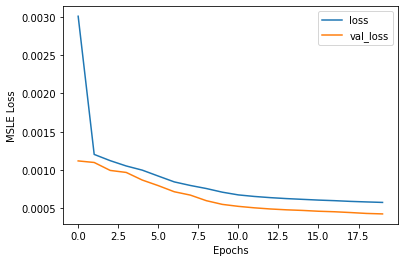

In [47]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [52]:
import tensorflow as tf
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  threshold = np.mean(reconstruction_errors.numpy()) \
   + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
  return preds

threshold = find_threshold(model, X_train_scaled)
print(f"Threshold: {threshold}")


4451/4451 [==============================] - 8s 2ms/step
Threshold: 0.0011249738850665893


In [54]:
predictions = get_predictions(model, X_test_scaled, threshold)
accuracy_score(predictions, y_test)

4451/4451 [==============================] - 7s 2ms/step


0.03758321395466419